<a href="https://colab.research.google.com/github/salmanromeo/CS_5683_Big_Data_Analytics/blob/main/Assignment_2_2_Latent_Factor_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**

In this assignment, we will experiment with latent factor model for movie recommendations. In particular, we will implement the latent factorization model that optimizes singular matrices **$P$** and **$Q$** with gradient descent. We will evaluate the performance of the model using the Root Mean Squared Error (RMSE) metric.

**Task**

Implement Stochastic Gradient Descent and optimize matrices P and Q. Choose $k=25$, $𝜆=0.1$, $𝜂$ with a very small number (start with $0.001$ or $0.01$) and number of algorithm training $iterations=40$. You can optimize all parameters as much as possible until you reach the steady state for $E$.

1.   **Plot the value of the objective function $E$ on the training set as a function of the number of iterations using the line plot.**
2.   **Plot the value of the objective function $E$ on the training set as a function of $k$ using a bar plot.**

**Implementation Tips:**

1. Initialization of $P$ and $Q$: Initialize $P$ and $Q$ matrices in such a way that $P_x$.${q_i}^T$ $∈[0,5]$. To achieve this, initialize all elements of $P$ and $Q$ to random values in $[0,√(5/𝑘)]$
2. Update equations: In each iteration, we update $p_x$ with $q_i$ and $q_i$ with $p_x$. Compute the new values of $p_x$ and $q_i$ using old values and then update vectors $p_x$ and $q_i$
3. Compute $E$ at the end of a full iteration of training. Computing $E$ in pieces during the iteration is incorrect since $P$ and $Q$ are still being updated
4. Fine-tuning: We expect you to fine-tune model parameters to get the best model. Try to utilize the data given in meta data to add more information to the model
5. Create a python function "**model_eval()**" for model evaluation. This function should take file paths of evaluation data, $P$, $Q$ as inputs and output RMSE. All pre-processing steps should be within this function. We will be using this function for evaluating with test data while grading

**Preprocessing Data**

In [2]:
import numpy as np
import pandas as pd

# Store training data
file_path = '/content/sample_data/Train_ratings.txt'

# Define the column names
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the text file
df_train = pd.read_csv(file_path, sep='::', engine='python', header=None, names=column_names)

# Display the DataFrame
df_train.head()

,user_id,item_id,rating,timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,2804,5,978300719
3,1,595,5,978824268
4,1,2398,4,978302281


In [4]:
# Store testing data
file_path = '/content/sample_data/Test_ratings.txt'

# Define the column names
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the text file
df_test = pd.read_csv(file_path, sep='::', engine='python', header=None, names=column_names)

# Display the DataFrame
df_test.head()

,user_id,item_id,rating,timestamp
0,1,2355,5,978824291
1,1,1197,3,978302268
2,1,1545,4,978824139
3,2,648,4,978299913
4,2,3030,4,978298434


In [11]:
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
import math

class Latent_Factor_Model:

    def __init__(self, n_items, n_users, k, init_sd = 0.1):
        self.k = k
        self.P = np.random.uniform(low=0.0, high=math.sqrt(5/k), size=(n_users, k))
        self.Q = np.random.uniform(low=0.0, high=math.sqrt(5/k), size=(n_items, k))

    def predict_rating(self, user_id, item_id) -> float:
        user_vec = self.P[user_id, :].reshape(1, self.k)
        item_vec = self.Q[item_id, :].reshape(1, self.k)
        return np.dot(user_vec, item_vec.T)

    def compute_rmse(self, ratings):
        actual_ratings = []
        predicted_ratings = []
        for user_id, item_id, rating in ratings:
            predicted = self.predict_rating(user_id, item_id)
            predicted_ratings.append(predicted)
            actual_ratings.append(rating)
        actual_ratings = np.asarray(actual_ratings, dtype=np.float32).reshape(-1, 1)
        predicted_ratings = np.asarray(predicted_ratings, dtype=np.float32).reshape(-1, 1)
        rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        return round(rmse, 4)

    def sgd(self, user_id, item_id, true_rating, learning_rate, lambda_):
        user_vec = self.P[user_id, :]
        item_vec = self.Q[item_id, :]
        error = true_rating - np.dot(user_vec, item_vec.T)
        self.P[user_id, :] -= learning_rate * ((-1) * (error - lambda_ * user_vec))
        self.Q[item_id, :] -= learning_rate * ((-1) * (error * user_vec - lambda_ * item_vec))

    def cost_function(self, user_id, item_id, true_rating, learning_rate, lambda_):
        user_vec = self.P[user_id, :]
        item_vec = self.Q[item_id, :]
        error = true_rating - np.dot(user_vec, item_vec.T)
        return (error**2) + (lambda_ * (norm(user_vec) + norm(item_vec)))

    def train_model(self, ratings, n_iter, learning_rate, lambda_):
        for iter in range(n_iter):
            total_error = 0
            for idx in np.random.permutation(len(ratings)):
                self.sgd(*ratings[idx], learning_rate, lambda_)
                total_error += self.cost_function(*ratings[idx], learning_rate, lambda_)
            yield iter + 1, total_error

In [14]:
import matplotlib.pyplot as plt

train_ratings = df_train[['user_id', 'item_id', 'rating']].to_numpy()
train_max = train_ratings.max(axis=0)

test_ratings = df_test[['user_id', 'item_id', 'rating']].to_numpy()
test_max = test_ratings.max(axis=0)

n_users = max(train_max[0], test_max[0])
print(n_users)

n_items = max(train_max[1], test_max[1])
print(n_items)

def run_Latent_Factor_Model(k, iter, learning_rate, lambda_):

    lf_model = Latent_Factor_Model(n_items + 1, n_users + 1, k)
    training_ratings, testing_ratings = train_ratings, test_ratings
    train_cost = np.zeros(iter)
    n_iter = np.arange(iter)

    for iter, total_cost in lf_model.train_model(train_ratings, iter, learning_rate, lambda_):
        train_cost[iter - 1] = total_cost

    # Plot E over the iteration
    plt.plot(n_iter, np.array(train_cost).reshape(iter, 1), color='red', label='Train')
    plt.ylabel('Total cost')
    plt.xlabel('Number of Iteration')
    plt.title('Training Cost over Iterations')
    plt.show()

    # Calculate RMSE
    print('Test RMSE:' + str(lf_model.compute_rmse(testing_ratings)))

    # Plot E as a function of k
    k_values = list(range(1, k + 1))
    k_costs = []

    for k in k_values:
        temp_model = Latent_Factor_Model(n_items + 1, n_users + 1, k)
        total_cost = sum([temp_model.cost_function(*data_point, learning_rate, lambda_) for data_point in training_ratings])
        k_costs.append(total_cost)

    plt.bar(k_values, k_costs, color='green')
    plt.ylabel('Total Cost')
    plt.xlabel('Number of Latent Factors (k)')
    plt.title('Objective Function as a Function of Latent Factors (k)')
    plt.show()

6040
3951


**Learning rate = 0.01**

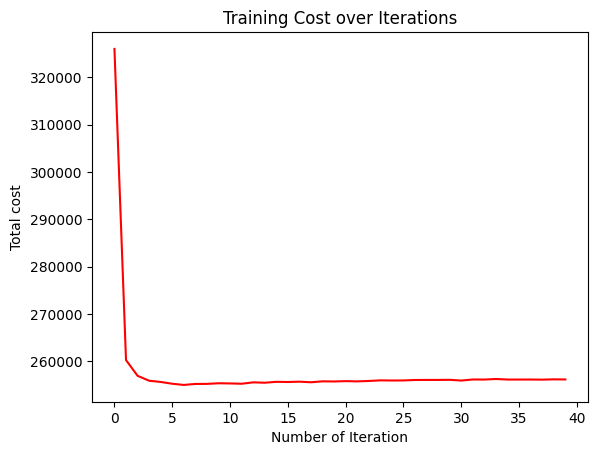

Test RMSE:1.3644


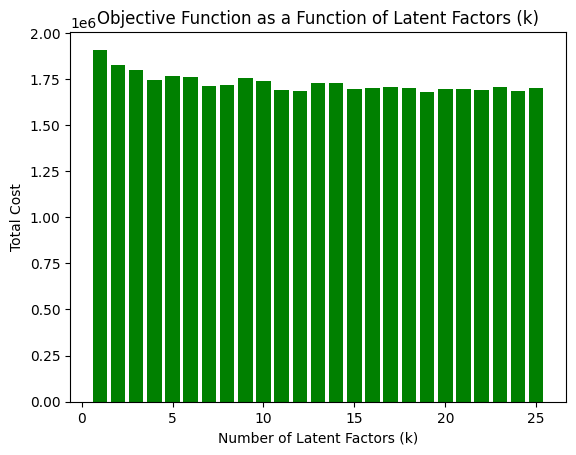

In [15]:
k = 25
iter = 40
lambda_= 0.1
learning_rate = 0.01 # 0.001
run_Latent_Factor_Model(k, iter, learning_rate, lambda_)

**Learning rate = 0.001**

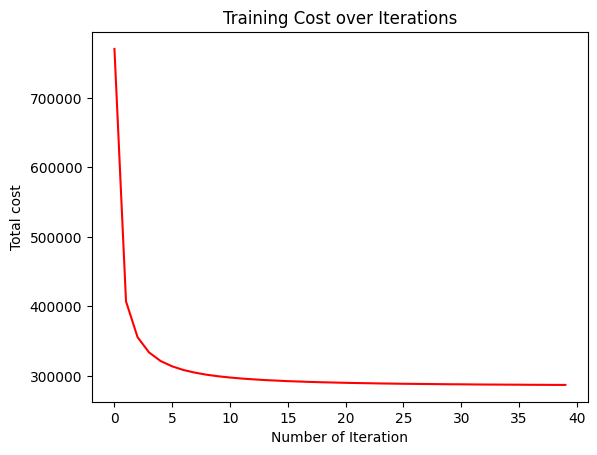

Test RMSE:1.6892


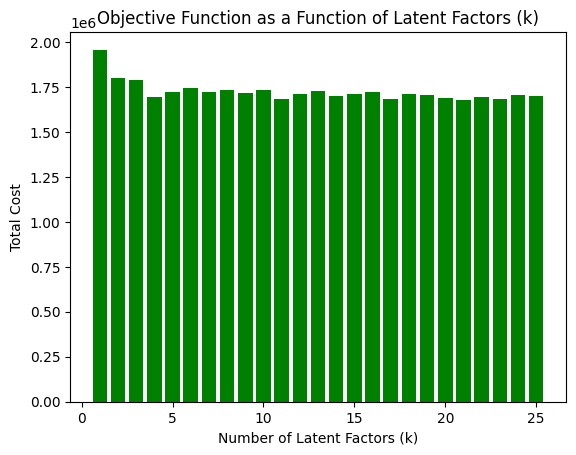

In [16]:
k = 25
iter = 40
lambda_= 0.1
learning_rate = 0.001 # 0.01
run_Latent_Factor_Model(k, iter, learning_rate, lambda_)

**Explain how fine-tuning affects the model performance (final RMSE) with the evaluation data.**

1. **Learning Rate**
*   If learning rate is too high, the updates to $P$ and $Q$ will be large, causing the model to overshoot the optimal solution. This leads to fluctuating cost values and unstable training, which results in a higher RMSE.
*   If learning rate is too low, the updates will be too small, slowing down the convergence. In this case, the model might get stuck in a local minimum or may require many more iterations to reach the optimal solution, resulting in a suboptimal RMSE.
*   Optimal setting: After experimentation, a moderate learning rate (e.g.,
Learning Rate = 0.01) can strike a balance, allowing the model to converge more smoothly, reducing the RMSE steadily across iterations.

2.   **Regularization (Lambda)**
*   If lambda is too high, the model will overly penalize large latent factors, which can lead to underfitting. The learned factors will be overly constrained, and the model will fail to capture important patterns in the data, resulting in a high RMSE.
*   If lambda is too low, the model may overfit the training data, capturing noise instead of true patterns. This will result in a good performance on the training set but poor generalization to the evaluation data, leading to a higher RMSE.

3.   **Number of Latent Factors (k)**
*   If k is too high, the model may overfit by learning very detailed latent representations that fit the training data but do not generalize well to new data, increasing RMSE on the evaluation set.
*   If k is too low, the model may underfit, failing to capture important patterns in user-item interactions. This results in an overly simplistic model that cannot predict ratings accurately, leading to a high RMSE.

4.   **Number of Iterations**
*   If the number of iterations is too low, the model may not converge fully, leaving it undertrained with higher RMSE.
*   If the number of iterations is too high, the model may start overfitting the training data, leading to a poorer generalization performance on the evaluation data, increasing RMSE.

Plotting the objective function $E$ over the number of iterations helps monitor the convergence of the model. A steady decrease in $E$ over iterations indicates that the model is learning and converging well.

However, adding meta-data helps the model learn more nuanced user-item relationships, which can reduce RMSE by improving the accuracy of the predictions, especially for users or items with sparse ratings.









**Model Evaluation**

In [18]:
from math import sqrt

def model_eval(evaluation_data_path, P, Q):

    # Load the evaluation data
    evaluation_data = np.loadtxt(evaluation_data_path, delimiter=',', dtype=int)
    df_eval = pd.DataFrame(evaluation_data, columns=['user_id', 'item_id', 'rating'])
    df_eval.head()

    # Extract user IDs, item IDs, and actual ratings from the evaluation data
    user_ids = evaluation_data[:, 0]
    item_ids = evaluation_data[:, 1]
    actual_ratings = evaluation_data[:, 2]

    # Initialize lists to store actual and predicted ratings
    predicted_ratings = []

    for user_id, item_id, actual_rating in zip(user_ids, item_ids, actual_ratings):
        # Predict the rating using the P and Q matrices
        user_factors = P[user_id, :]
        item_factors = Q[item_id, :]
        predicted_rating = np.dot(user_factors, item_factors)
        predicted_ratings.append(predicted_rating)

    # Calculate RMSE
    actual_rating = np.asarray(actual_ratings, dtype=np.float32).reshape(-1, 1)
    predicted_rating = np.asarray(predicted_ratings, dtype=np.float32).reshape(-1, 1)
    RMSE = sqrt(mean_squared_error(actual_rating, predicted_rating))

    return RMSE